<a href="https://colab.research.google.com/gist/benhk2005/3280c3c556962a792988898f728c1140/2023-jun-6-2227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
GLOBAL_BATCH_SIZE = 32
GLOBAL_LEARNING_RATE = 0.001

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/StockData/MSFT.csv')
df

,Date,Close
0,2/6/2014,40.790001
1,3/6/2014,40.290001
2,4/6/2014,40.320000
3,5/6/2014,41.209999
4,6/6/2014,41.480000
...,...,...
2260,23/5/2023,315.260010
2261,24/5/2023,313.850006
2262,25/5/2023,325.920013
2263,26/5/2023,332.890015


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2265 non-null   object 
 1   Close   2265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.5+ KB


In [ ]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df = df
new_df.describe()

,Close
count,2265.000000
mean,142.370631
std,91.763318
min,40.290001
25%,57.419998
50%,108.300003
75%,231.600006
max,343.109985


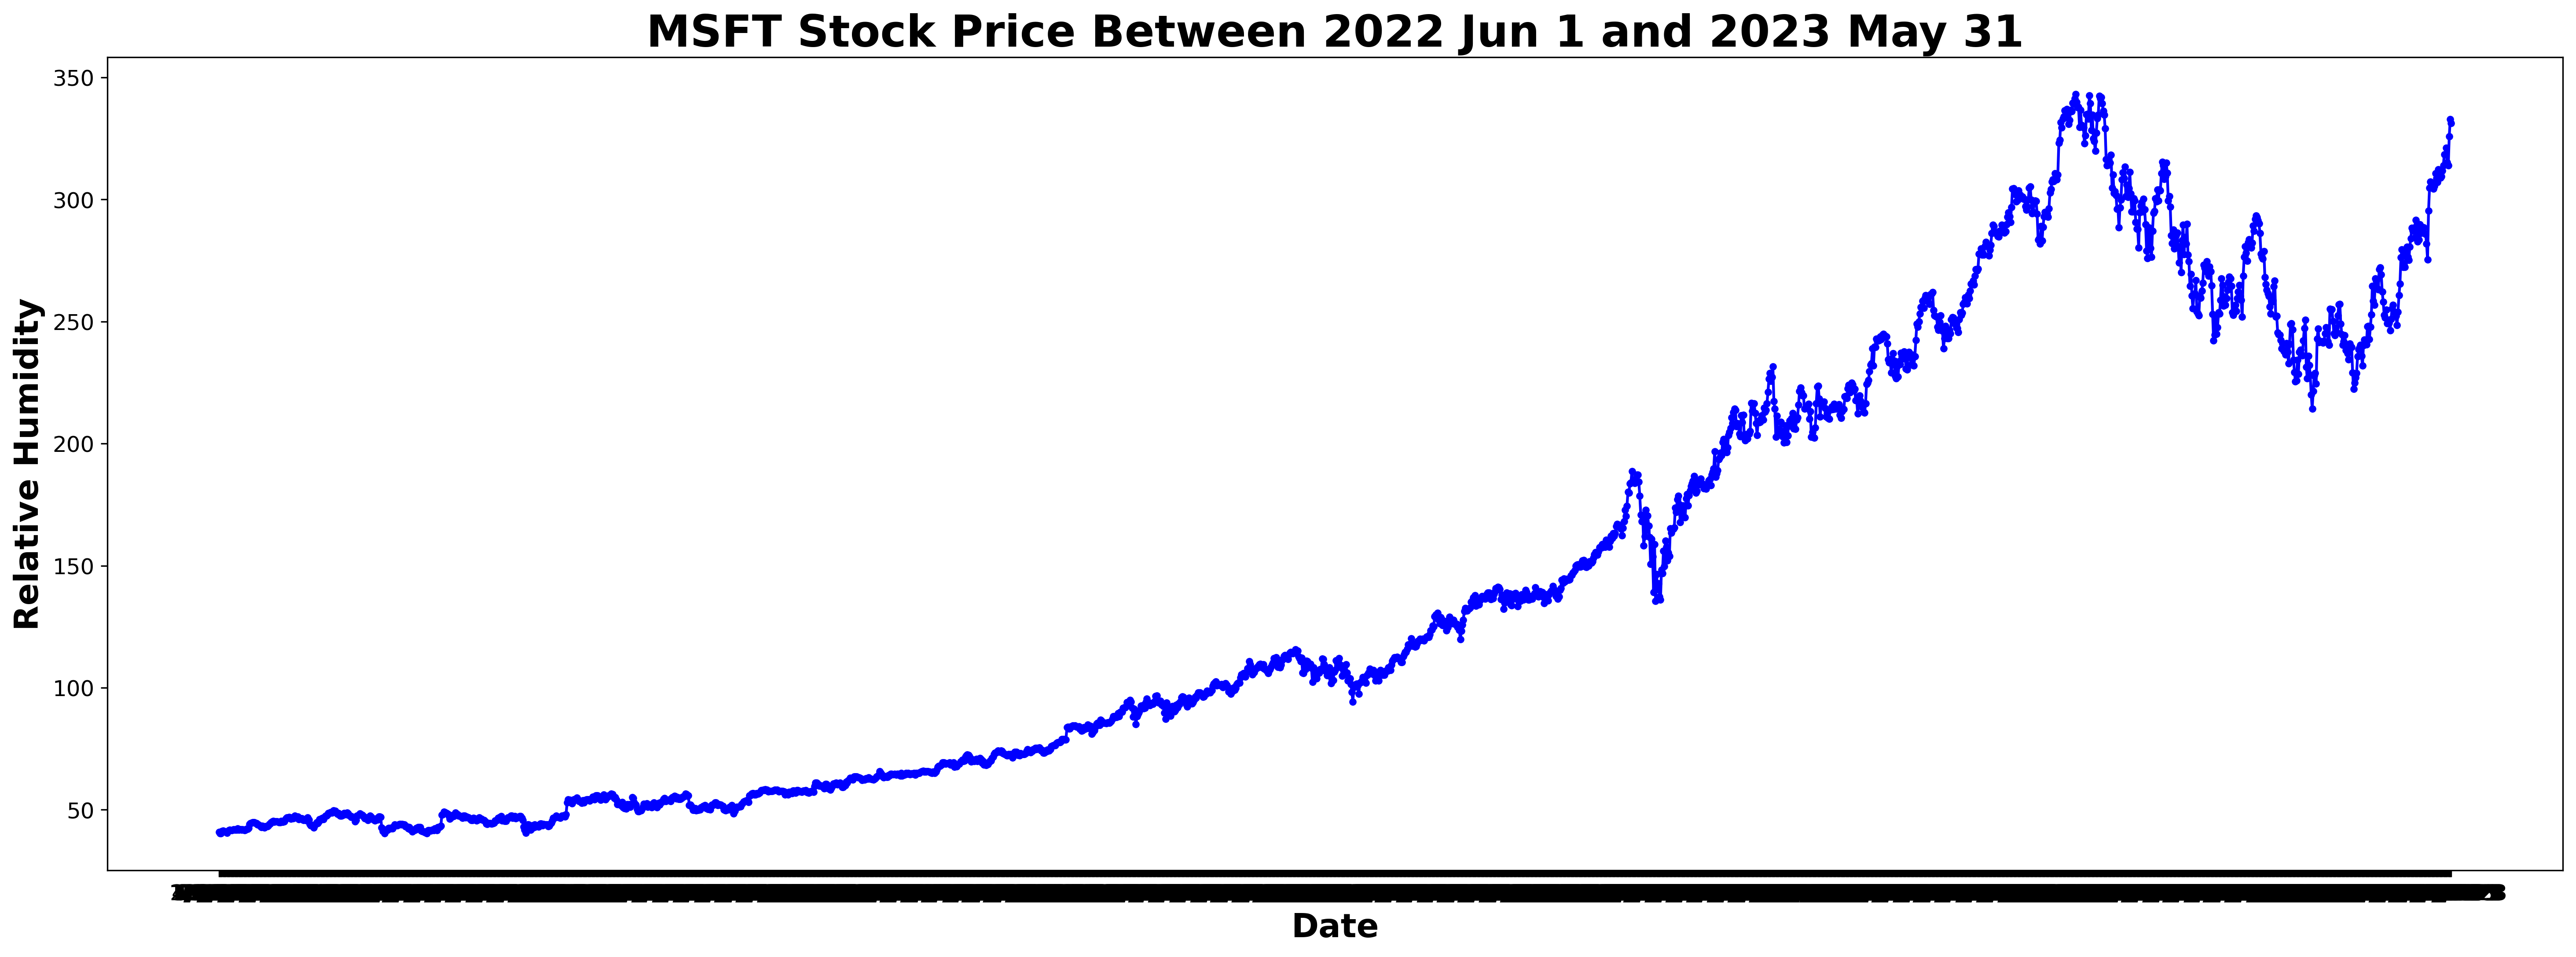

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('MSFT Stock Price Between 2022 Jun 1 and 2023 May 31',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [ ]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2/6/2014,40.790001,NaN,NaN,NaN
1,3/6/2014,40.290001,40.790001,NaN,NaN
2,4/6/2014,40.320000,40.290001,40.790001,NaN
3,5/6/2014,41.209999,40.320000,40.290001,40.790001
4,6/6/2014,41.480000,41.209999,40.320000,40.290001


In [ ]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,5/6/2014,41.209999,40.320000,40.290001,40.790001
1,6/6/2014,41.480000,41.209999,40.320000,40.290001
2,9/6/2014,41.270000,41.480000,41.209999,40.320000
3,10/6/2014,41.110001,41.270000,41.480000,41.209999
4,11/6/2014,40.860001,41.110001,41.270000,41.480000
...,...,...,...,...,...
2257,23/5/2023,315.260010,321.179993,318.339996,318.519989
2258,24/5/2023,313.850006,315.260010,321.179993,318.339996
2259,25/5/2023,325.920013,313.850006,315.260010,321.179993
2260,26/5/2023,332.890015,325.920013,313.850006,315.260010


# 3. Data preprocessing under time-series structure

In [ ]:
# Train data
Forecast_train_data=clean_df.iloc[0:1938,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,5/6/2014,41.209999,40.320000,40.290001,40.790001
1,6/6/2014,41.480000,41.209999,40.320000,40.290001
2,9/6/2014,41.270000,41.480000,41.209999,40.320000
3,10/6/2014,41.110001,41.270000,41.480000,41.209999
4,11/6/2014,40.860001,41.110001,41.270000,41.480000
...,...,...,...,...,...
1933,7/2/2022,300.950012,305.940002,301.250000,313.459991
1934,8/2/2022,304.559998,300.950012,305.940002,301.250000
1935,9/2/2022,311.209991,304.559998,300.950012,305.940002
1936,10/2/2022,302.380005,311.209991,304.559998,300.950012


In [ ]:
# Test data
Forecast_test_data=clean_df.iloc[1938:1938+323,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
1938,14/2/2022,295.000000,295.040009,302.380005,311.209991
1939,15/2/2022,300.470001,295.000000,295.040009,302.380005
1940,16/2/2022,299.500000,300.470001,295.000000,295.040009
1941,17/2/2022,290.730011,299.500000,300.470001,295.000000
1942,18/2/2022,287.929993,290.730011,299.500000,300.470001
...,...,...,...,...,...
2256,22/5/2023,321.179993,318.339996,318.519989,314.000000
2257,23/5/2023,315.260010,321.179993,318.339996,318.519989
2258,24/5/2023,313.850006,315.260010,321.179993,318.339996
2259,25/5/2023,325.920013,313.850006,315.260010,321.179993


# 4. Prepare time-series data for train/validation structure manually

# Rolling window

In [ ]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:966,:].copy()
Rol_val_1=Forecast_train_data.iloc[966:966+323,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[320:1289,:].copy()
Rol_val_2=Forecast_train_data.iloc[1289:1289+323,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[643:1612,:].copy()
Rol_val_3=Forecast_train_data.iloc[1612:1612+323,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [ ]:
##1
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()


In [ ]:
scaled_x_val.describe()

,Lag_1,Lag_2,Lag_3
count,323.000000,323.000000,323.000000
mean,0.424117,0.421322,0.424458
std,0.238728,0.237883,0.234661
min,0.000000,0.000000,0.000000
25%,0.250154,0.247072,0.252999
50%,0.369427,0.369427,0.375280
75%,0.561229,0.555887,0.554584
max,1.000000,1.000000,1.000000


# 6. Creating Net 

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.000531,0.000000,0.008853
1,0.016289,0.000531,0.000000
2,0.021069,0.016289,0.000531
3,0.017351,0.021069,0.016289
4,0.014518,0.017351,0.021069


In [ ]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})
#get_custom_objects().update({'my_MAPE': MRAE_calculate})

# Sequential style coding for creating net

In [ ]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

model.add(Dropout(rate=0.2))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='linear'))

model.add(Dense(units=48, activation='relu'))

model.add(Dropout(rate=0.4))

model.add(Dense(units=96, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=GLOBAL_LEARNING_RATE,beta_1=0.95)
model.compile(loss='my_RMSE',optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 96)                4

# 7. Fit the model (train/validation)

# Rolling 1

In [ ]:
##1
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()


In [ ]:
scaled_x_val.describe()

,Lag_1,Lag_2,Lag_3
count,323.000000,323.000000,323.000000
mean,0.424117,0.421322,0.424458
std,0.238728,0.237883,0.234661
min,0.000000,0.000000,0.000000
25%,0.250154,0.247072,0.252999
50%,0.369427,0.369427,0.375280
75%,0.561229,0.555887,0.554584
max,1.000000,1.000000,1.000000


In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=GLOBAL_BATCH_SIZE,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
31/31 [==============================] - 1s 15ms/step - loss: 57.5513 - mean_absolute_percentage_error: 98.7416 - val_loss: 108.4758 - val_mean_absolute_percentage_error: 97.7428
Epoch 2/300
31/31 [==============================] - 0s 6ms/step - loss: 51.0242 - mean_absolute_percentage_error: 87.5019 - val_loss: 91.2538 - val_mean_absolute_percentage_error: 82.3818
Epoch 3/300
31/31 [==============================] - 0s 7ms/step - loss: 21.3892 - mean_absolute_percentage_error: 36.4294 - val_loss: 31.0830 - val_mean_absolute_percentage_error: 28.7252
Epoch 4/300
31/31 [==============================] - 0s 7ms/step - loss: 11.5626 - mean_absolute_percentage_error: 19.6059 - val_loss: 54.9492 - val_mean_absolute_percentage_error: 49.9810
Epoch 5/300
31/31 [==============================] - 0s 8ms/step - loss: 9.3233 - mean_absolute_percentage_error: 15.8294 - val_loss: 48.0667 - val_mean_absolute_percentage_error: 43.8259
Epoch 6/300
31/31 [==============================] - 0

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

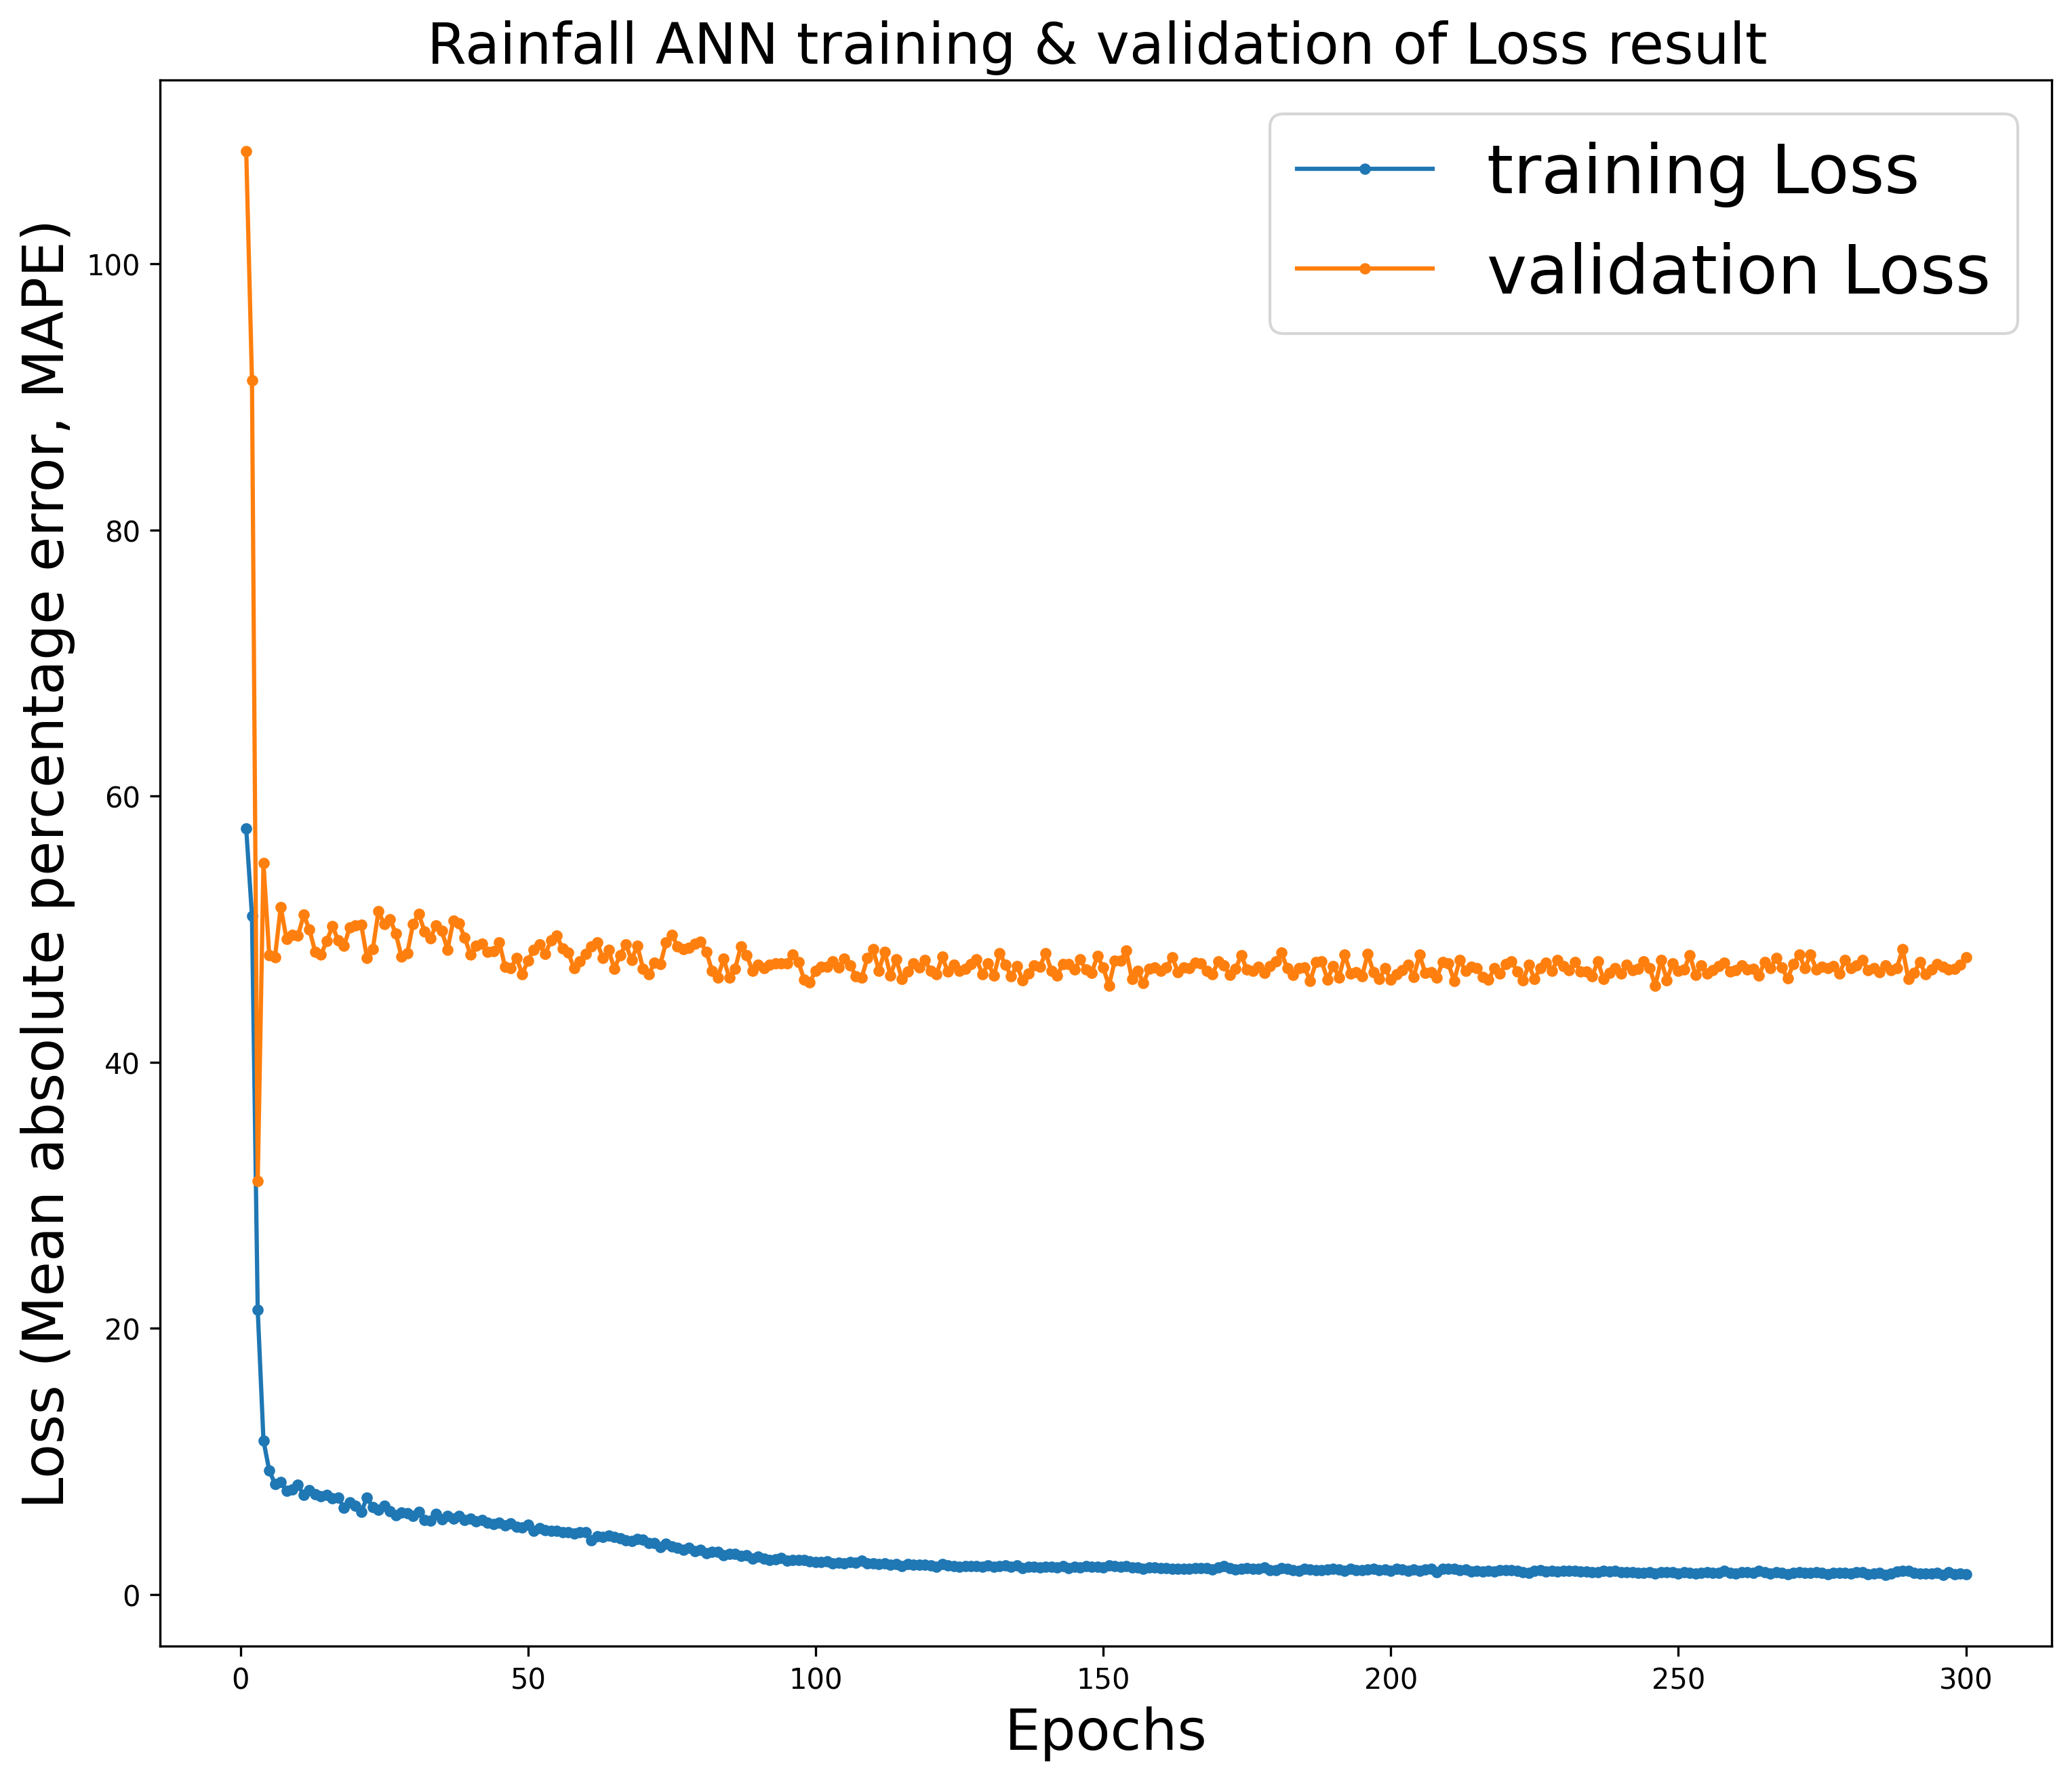

In [ ]:

# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean absolute percentage error, MAPE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

# Rolling 2

In [ ]:
##1
#set x (make prediction)
# Train
x_train=Rol_training_2.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_2.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_2['Close'].copy()
y_val=Rol_val_2['Close'].copy()


In [ ]:
x_train.describe()

,Lag_1,Lag_2,Lag_3
count,969.000000,969.000000,969.000000
mean,80.163375,80.067193,79.971022
std,25.201565,25.165035,25.124966
min,43.040001,43.040001,43.040001
25%,57.389999,57.250000,57.250000
50%,73.160004,73.050003,73.040001
75%,102.320000,102.190002,102.120003
max,138.899994,138.899994,138.899994


In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=GLOBAL_BATCH_SIZE,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
31/31 [==============================] - 0s 6ms/step - loss: 9.7090 - mean_absolute_percentage_error: 11.0130 - val_loss: 97.4976 - val_mean_absolute_percentage_error: 57.4992
Epoch 2/300
31/31 [==============================] - 0s 5ms/step - loss: 4.5448 - mean_absolute_percentage_error: 5.0241 - val_loss: 91.2663 - val_mean_absolute_percentage_error: 54.1954
Epoch 3/300
31/31 [==============================] - 0s 6ms/step - loss: 3.6068 - mean_absolute_percentage_error: 4.0525 - val_loss: 90.9950 - val_mean_absolute_percentage_error: 54.0497
Epoch 4/300
31/31 [==============================] - 0s 5ms/step - loss: 3.6634 - mean_absolute_percentage_error: 4.0028 - val_loss: 91.6252 - val_mean_absolute_percentage_error: 54.4413
Epoch 5/300
31/31 [==============================] - 0s 4ms/step - loss: 3.3355 - mean_absolute_percentage_error: 3.6428 - val_loss: 90.6231 - val_mean_absolute_percentage_error: 53.9215
Epoch 6/300
31/31 [==============================] - 0s 5ms/step

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

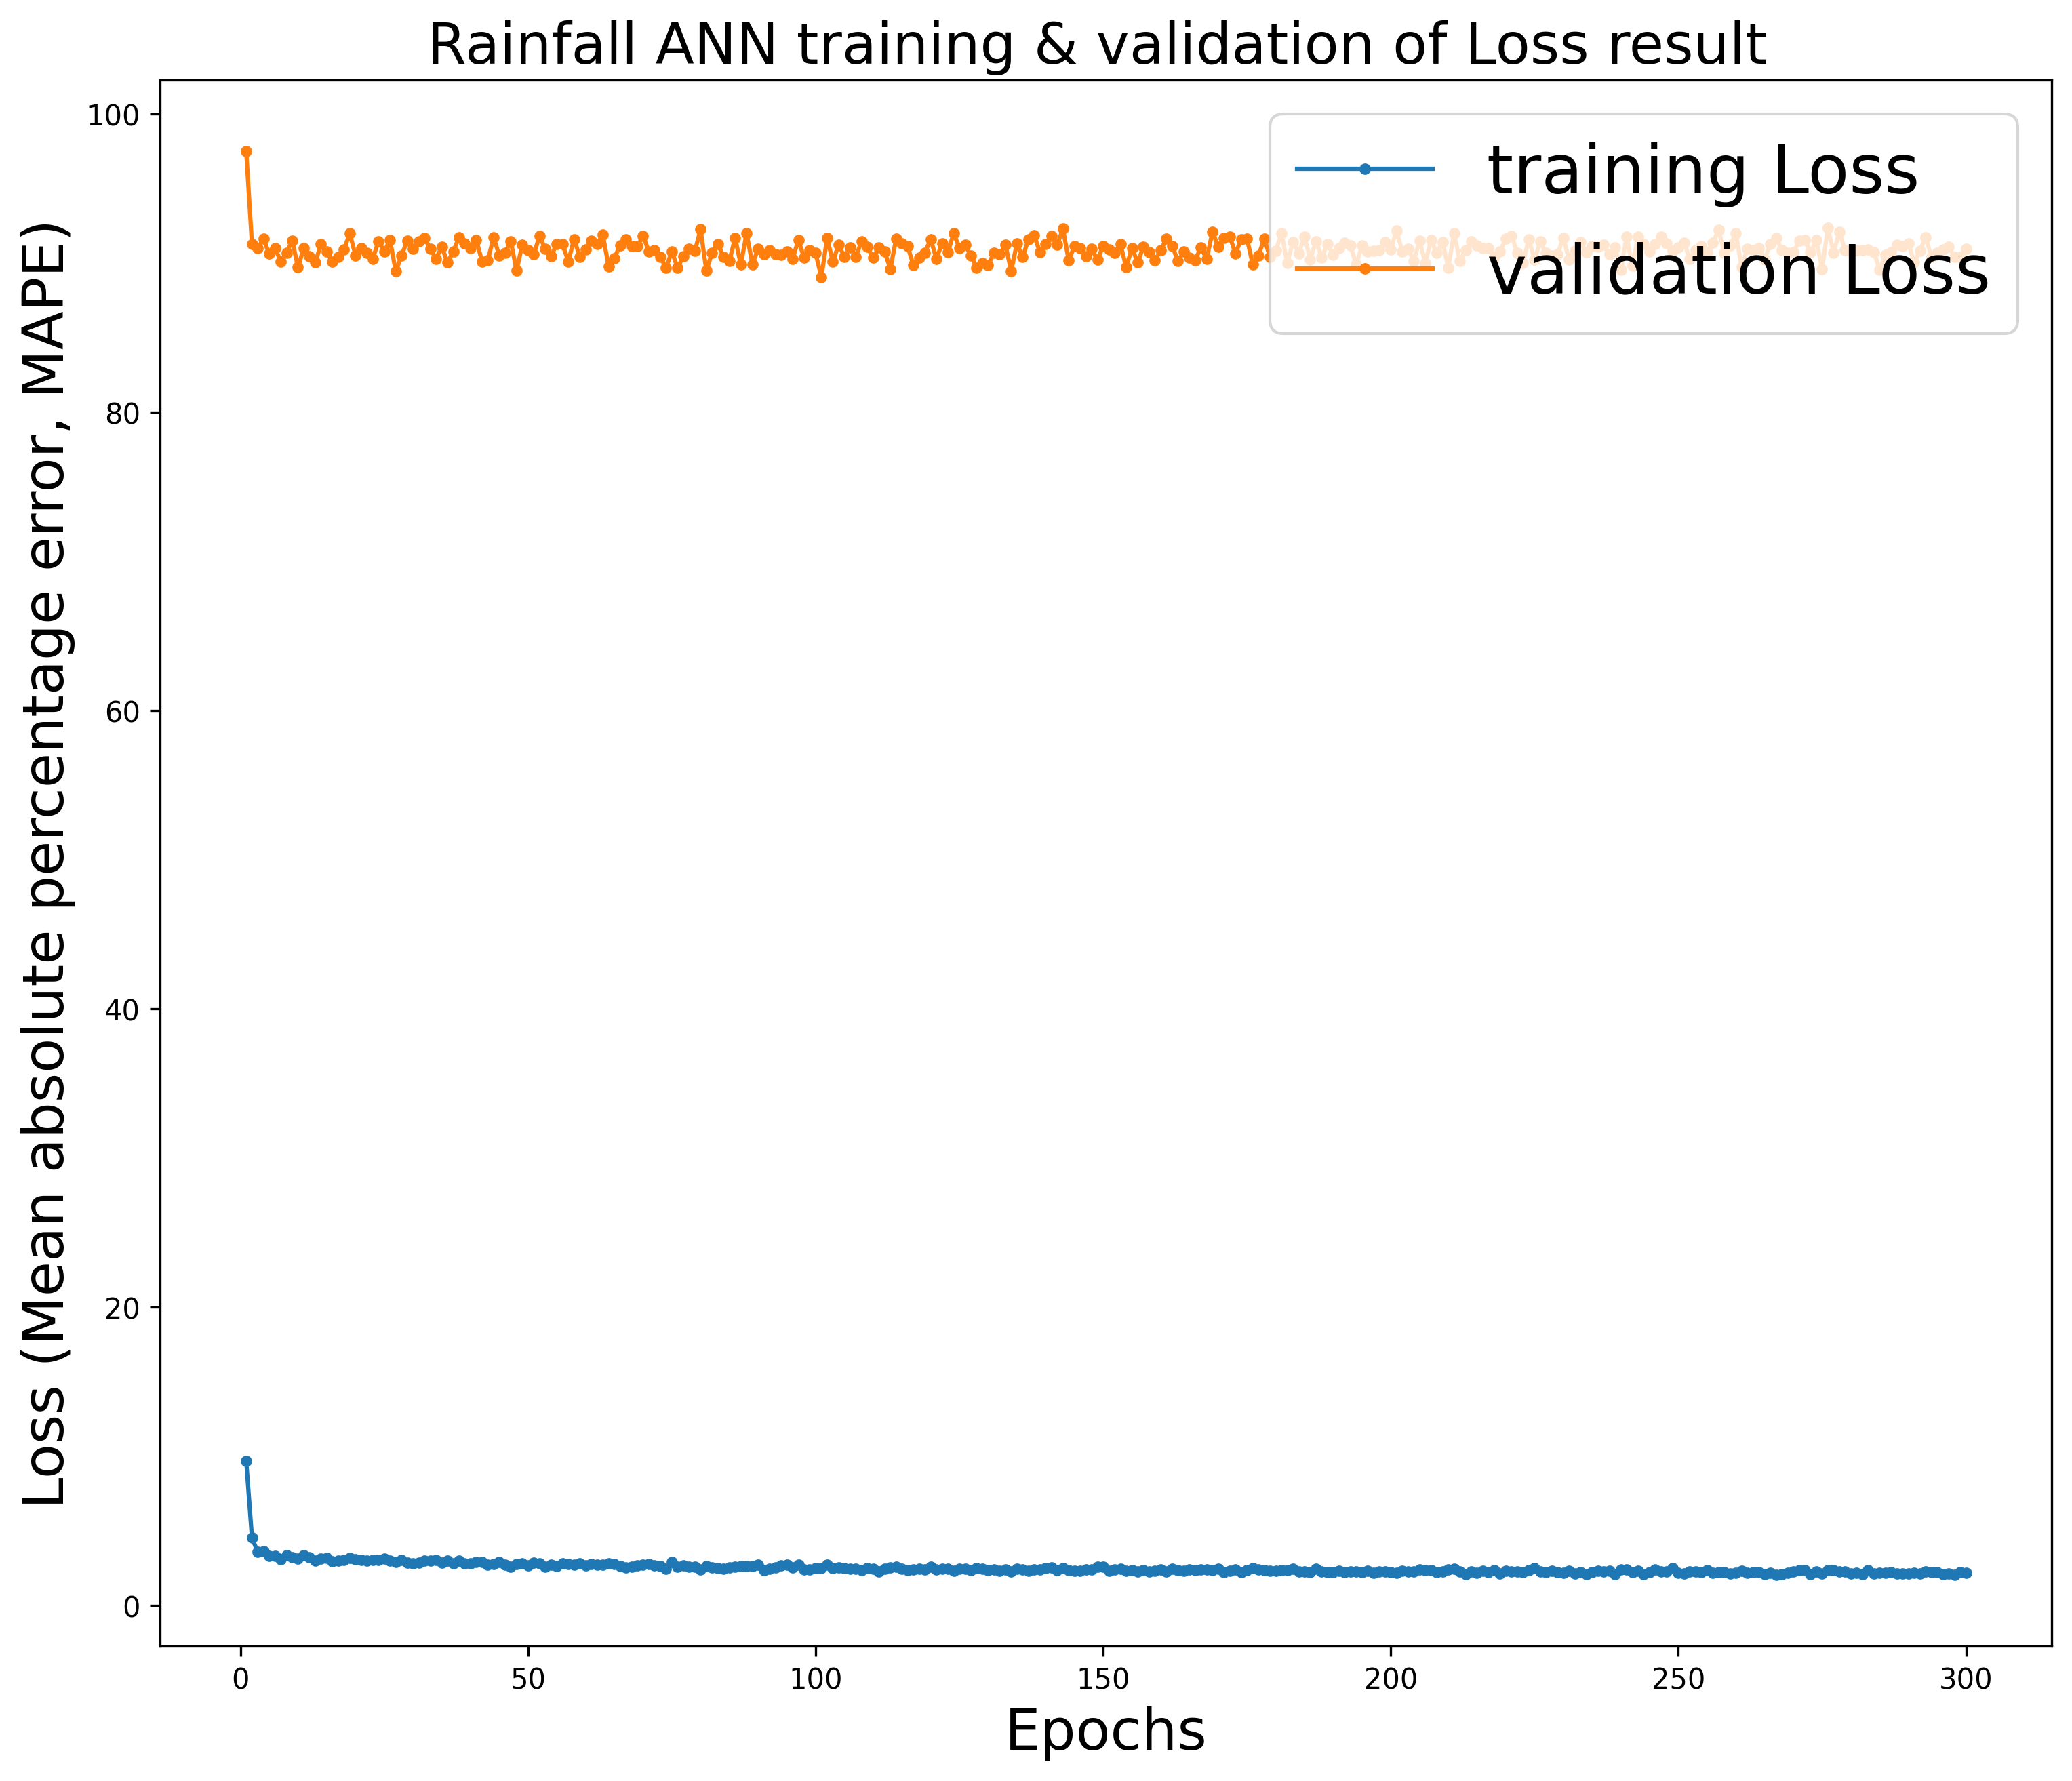

In [ ]:

# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean absolute percentage error, MAPE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

# Rolling 3

In [ ]:
##1
#set x (make prediction)
# Train
x_train=Rol_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_3['Close'].copy()
y_val=Rol_val_3['Close'].copy()


In [ ]:
x_train.describe()

,Lag_1,Lag_2,Lag_3
count,969.000000,969.000000,969.000000
mean,119.425686,119.274541,119.115686
std,43.940972,43.880674,43.807882
min,62.139999,62.139999,62.139999
25%,84.470001,84.269997,84.260002
50%,108.209999,108.209999,108.169998
75%,144.059998,143.720001,143.369995
max,231.649994,231.649994,231.649994


In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=GLOBAL_BATCH_SIZE,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
31/31 [==============================] - 0s 7ms/step - loss: 26.2791 - mean_absolute_percentage_error: 20.9755 - val_loss: 112.2338 - val_mean_absolute_percentage_error: 43.3795
Epoch 2/300
31/31 [==============================] - 0s 6ms/step - loss: 10.6170 - mean_absolute_percentage_error: 7.8333 - val_loss: 123.0904 - val_mean_absolute_percentage_error: 47.1878
Epoch 3/300
31/31 [==============================] - 0s 5ms/step - loss: 6.3238 - mean_absolute_percentage_error: 4.7639 - val_loss: 132.6312 - val_mean_absolute_percentage_error: 50.3884
Epoch 4/300
31/31 [==============================] - 0s 5ms/step - loss: 6.1616 - mean_absolute_percentage_error: 4.6407 - val_loss: 132.9165 - val_mean_absolute_percentage_error: 50.5851
Epoch 5/300
31/31 [==============================] - 0s 5ms/step - loss: 5.7749 - mean_absolute_percentage_error: 4.2823 - val_loss: 125.1612 - val_mean_absolute_percentage_error: 47.8892
Epoch 6/300
31/31 [==============================] - 0s 4

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

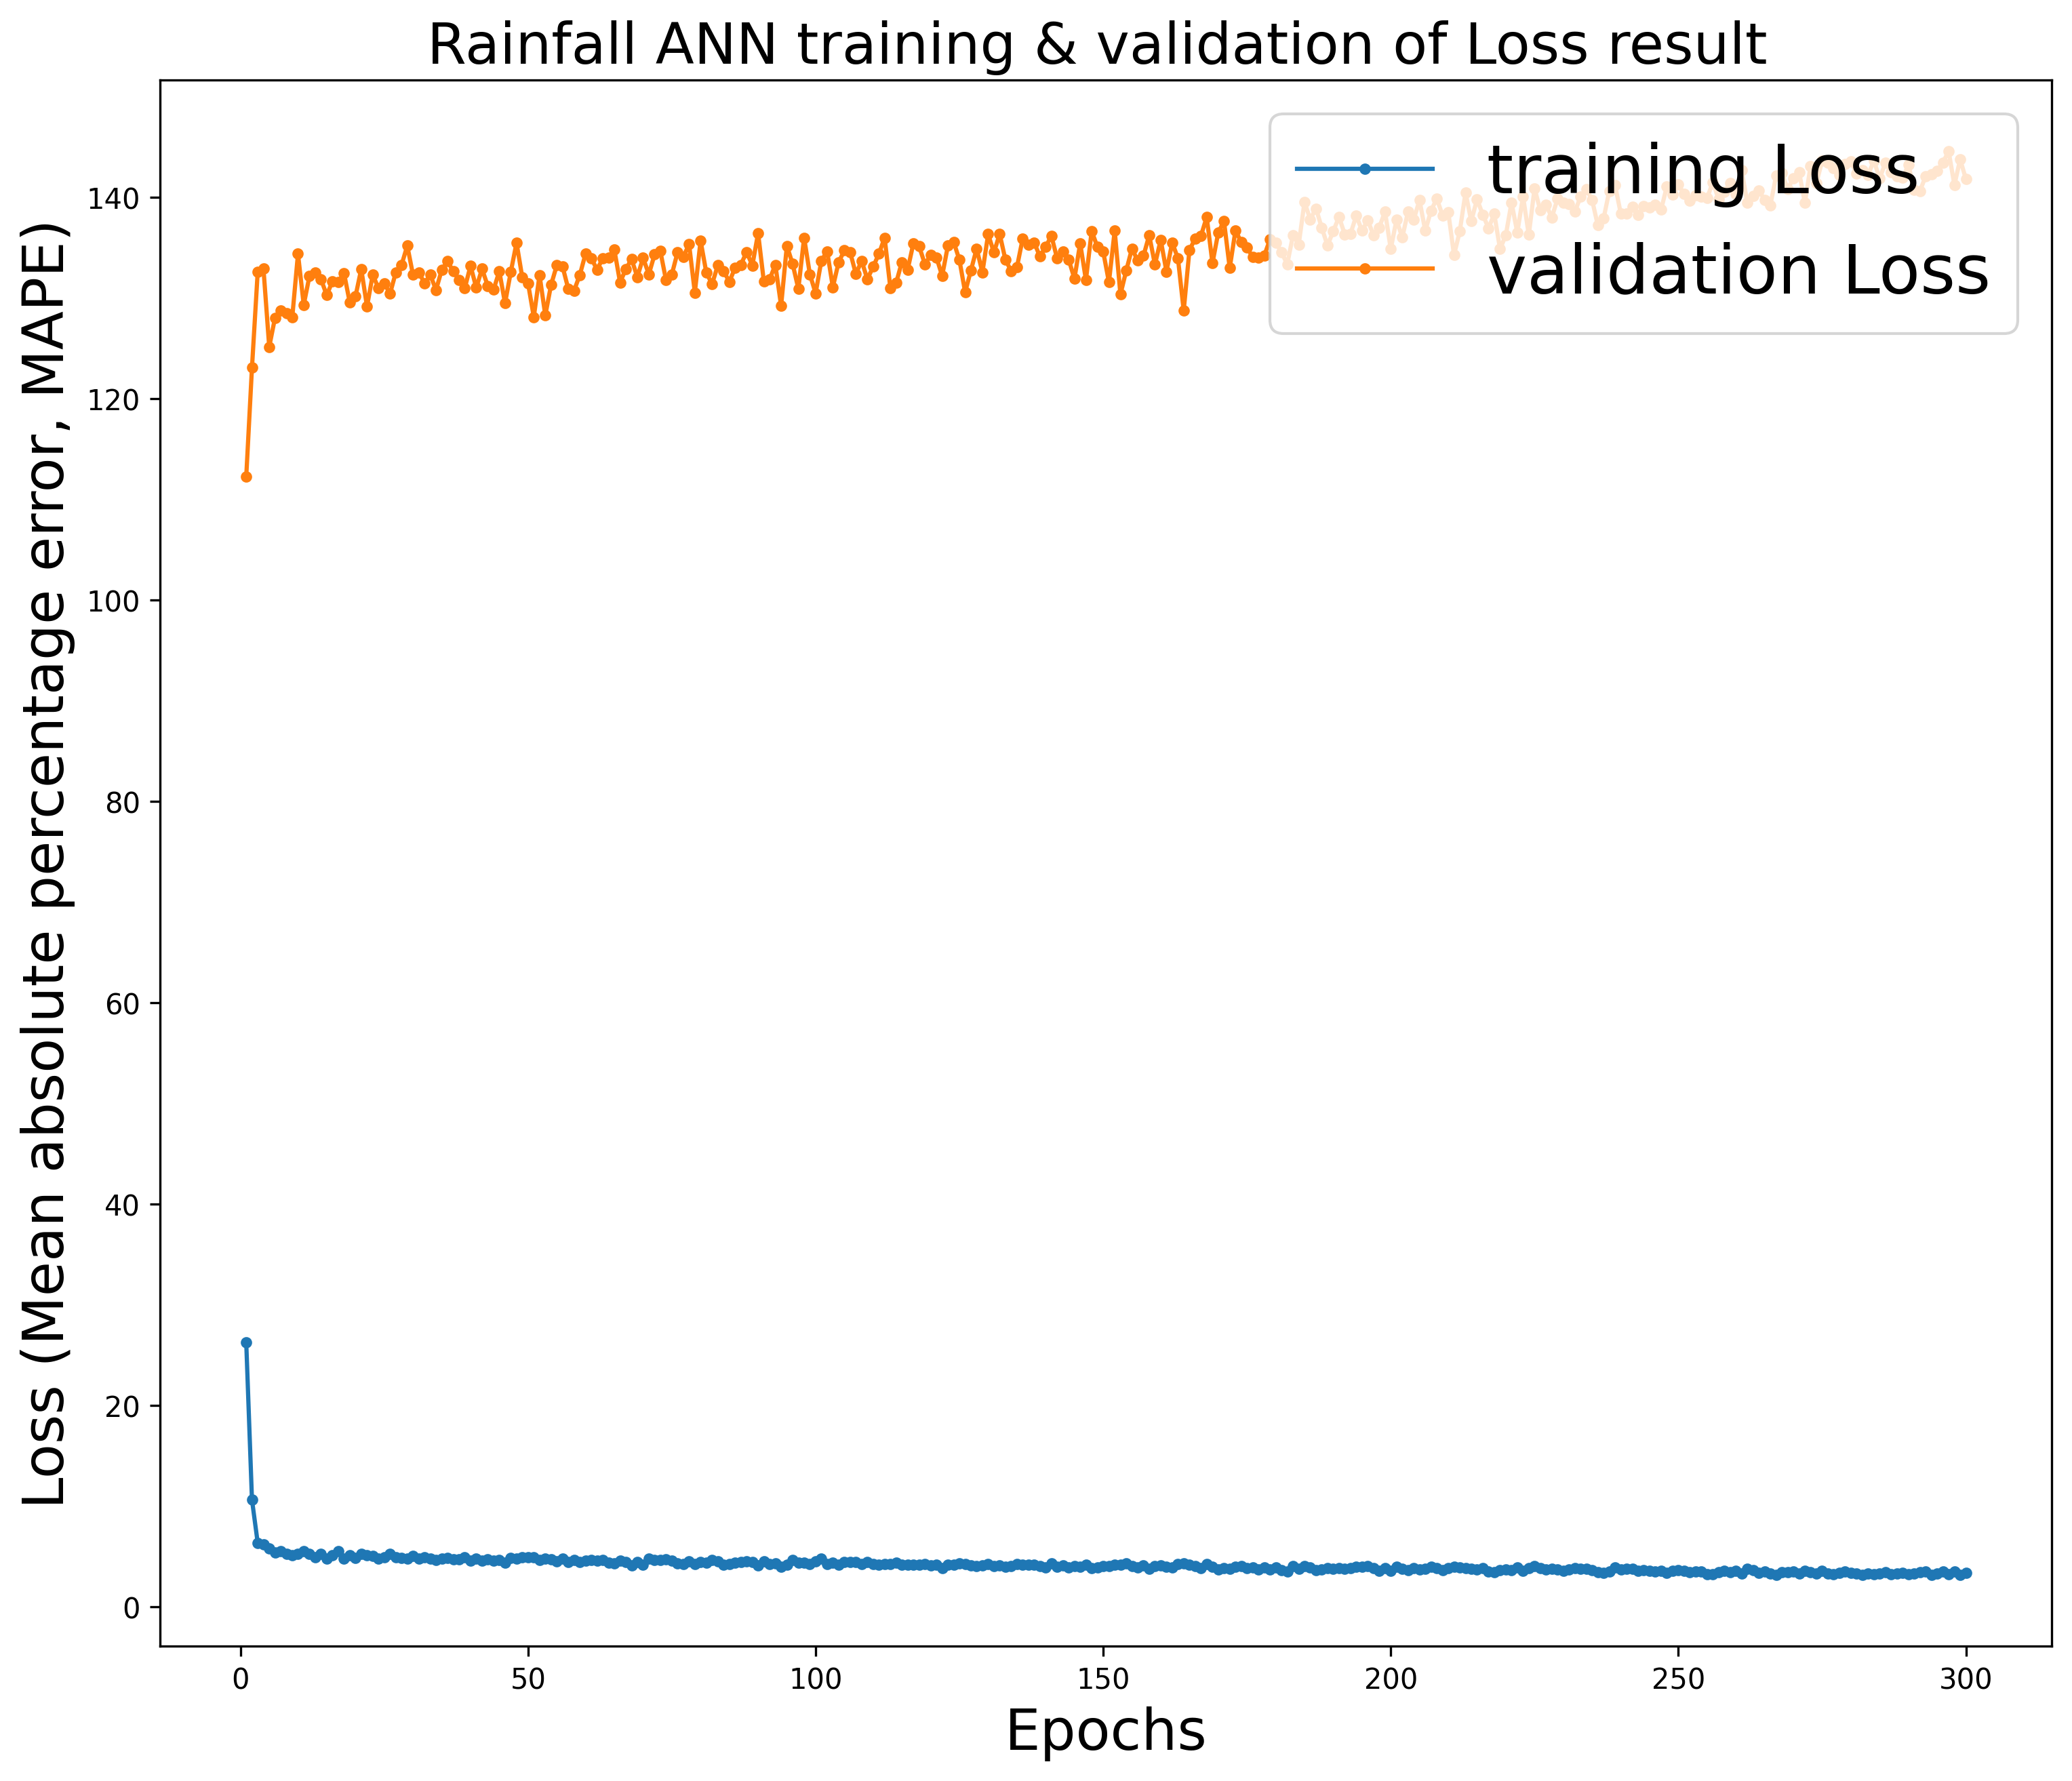

In [ ]:

# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean absolute percentage error, MAPE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [ ]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [ ]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# 6.2 Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

Fmodel.add(Dropout(rate=0.2))

# 6.4 Add third hidden layer
Fmodel.add(Dense(units=24, activation='linear'))

Fmodel.add(Dense(units=48, activation='relu'))

Fmodel.add(Dropout(rate=0.4))

Fmodel.add(Dense(units=96, activation='relu'))

# 6.5 Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=GLOBAL_LEARNING_RATE,beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 96)                4

In [ ]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=GLOBAL_BATCH_SIZE,verbose=1)

Epoch 1/300
61/61 [==============================] - 1s 3ms/step - loss: 48.0230 - mean_absolute_percentage_error: 39.7345
Epoch 2/300
61/61 [==============================] - 0s 3ms/step - loss: 21.5459 - mean_absolute_percentage_error: 17.8188
Epoch 3/300
61/61 [==============================] - 0s 3ms/step - loss: 17.4479 - mean_absolute_percentage_error: 14.1468
Epoch 4/300
61/61 [==============================] - 0s 3ms/step - loss: 15.4419 - mean_absolute_percentage_error: 12.6837
Epoch 5/300
61/61 [==============================] - 0s 4ms/step - loss: 14.1795 - mean_absolute_percentage_error: 11.5198
Epoch 6/300
61/61 [==============================] - 0s 4ms/step - loss: 13.0908 - mean_absolute_percentage_error: 10.7542
Epoch 7/300
61/61 [==============================] - 0s 4ms/step - loss: 12.4564 - mean_absolute_percentage_error: 10.1944
Epoch 8/300
61/61 [==============================] - 0s 4ms/step - loss: 11.5361 - mean_absolute_percentage_error: 9.5371
Epoch 9/300
61/61

In [ ]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/House_Rent_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [ ]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1938,14/2/2022,295.000000,145.630005,149.369995
1939,15/2/2022,300.470001,144.949997,155.520004
1940,16/2/2022,299.500000,146.750000,152.750000
1941,17/2/2022,290.730011,146.440002,144.290009
1942,18/2/2022,287.929993,143.169998,144.759995
...,...,...,...,...
2256,22/5/2023,321.179993,155.610001,165.569992
2257,23/5/2023,315.260010,157.050003,158.210007
2258,24/5/2023,313.850006,154.660004,159.190002
2259,25/5/2023,325.920013,154.149994,171.770019


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 136.031
MSE: 18683.256
RMSE: 136.687
MAPE: 50.988 %
SMAPE: 68.449 %
RAE: 6.563
MRAE: 0.02031979605582229
MdRAE: 7.091 bench: 266.683
RSE: 31.078
RRSE: 5.575


#  Plot for comparing true value & predicted value 

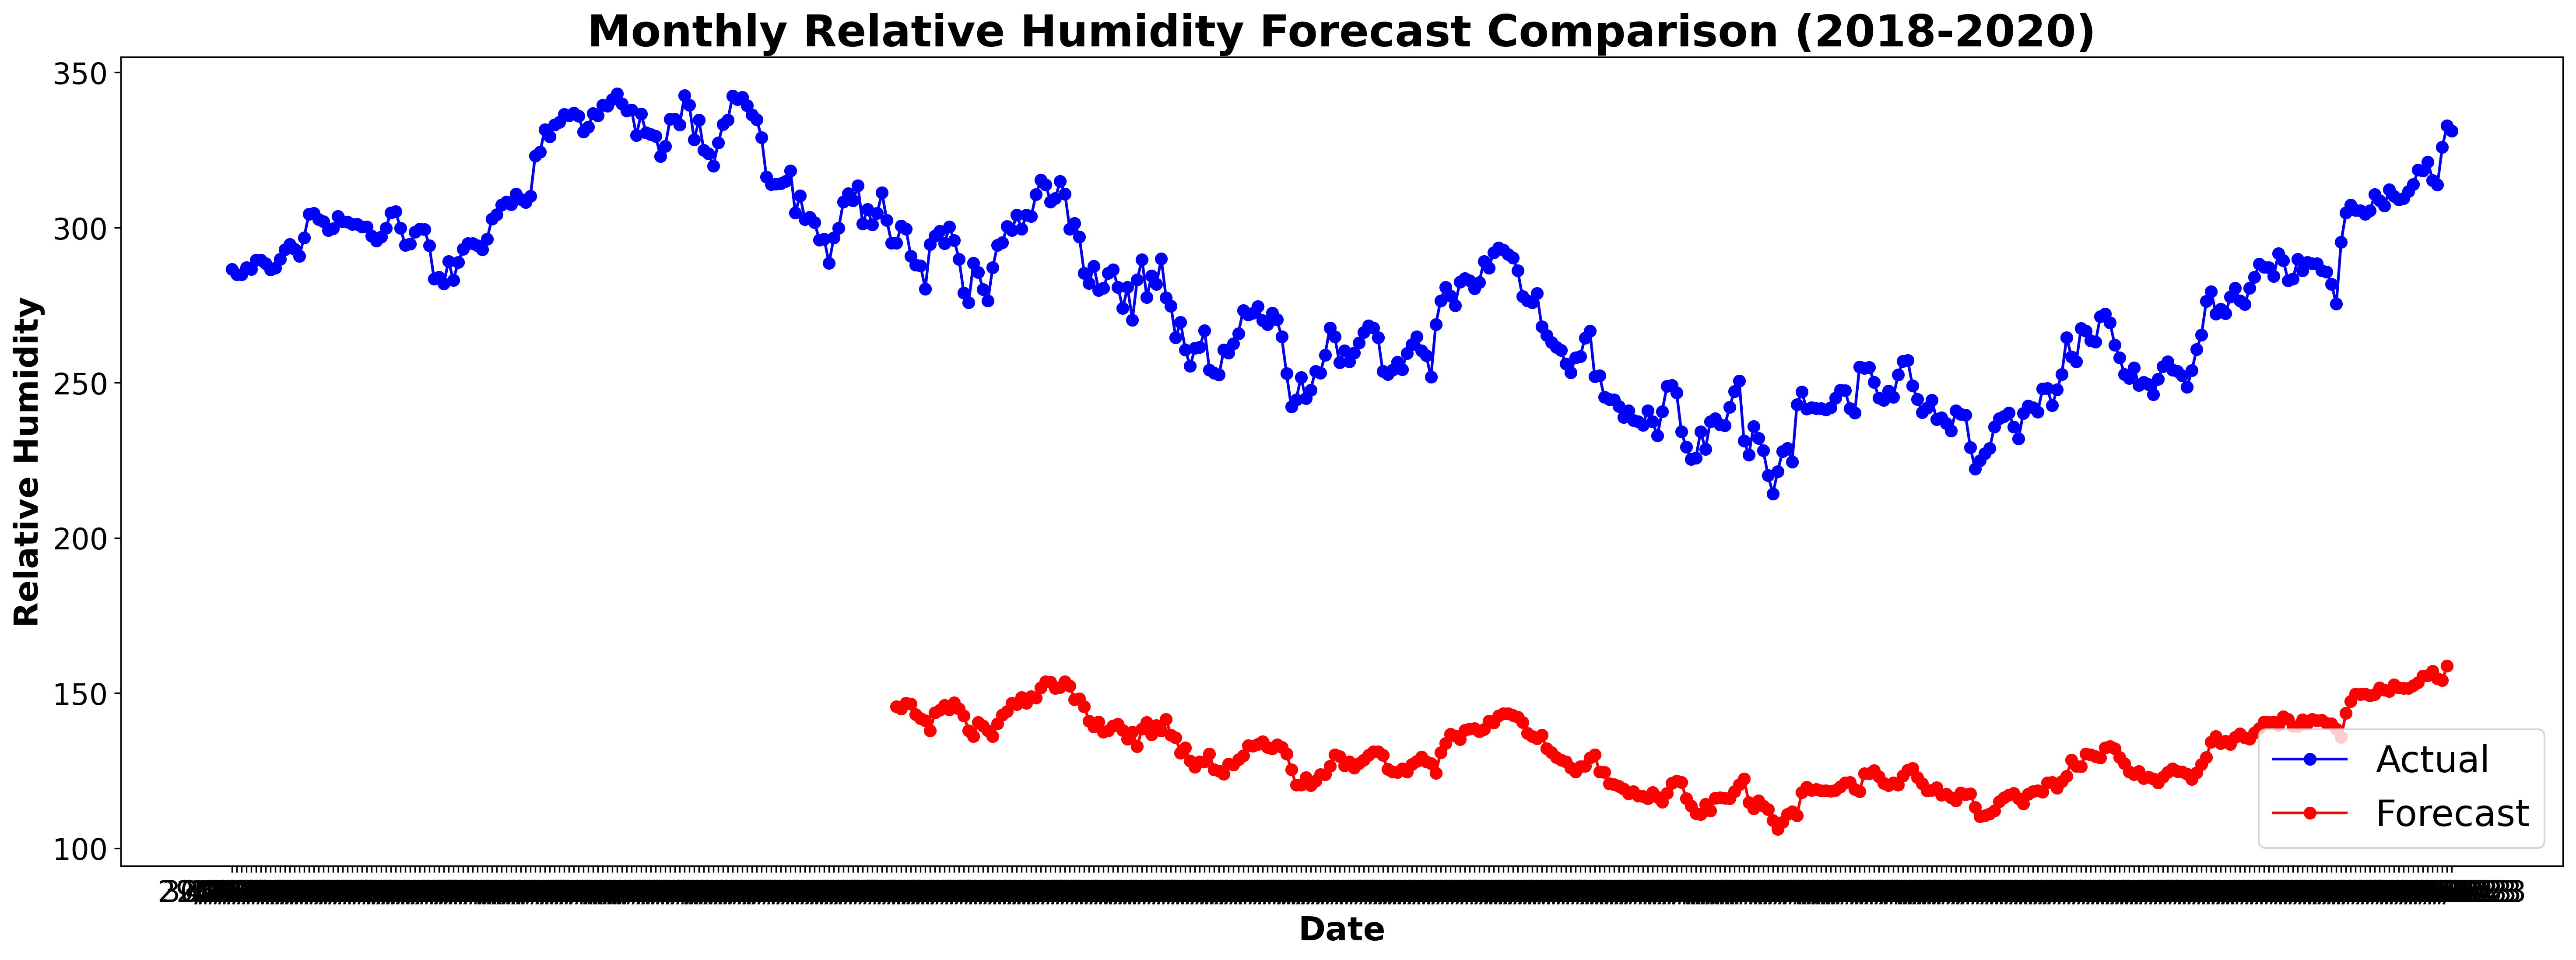

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[1800:,0],clean_df.iloc[1800:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()